# Orbits
created by: Wesley Terrill (04/22/2019)<br/>
revised on: (04/22/2019)

The two body potential energy is given by:<br/>
$U(r) = -G \frac{m_1 m_2}{r}$<br/>
To solve in cartesian coordinates, convert r to cartesian coordinates for each body 1 and 2.<br/>

So <br/> 
$
r = \sqrt{(x_1-x_2)^2 + (y_1-y_2)^2}
$

The potential then becomes: <br/>
$
U(x_1, x_2, y_1, y_2) = -G \frac{m_1 m_2}{\sqrt{(x_1-x_2)^2 + (y_1-y_2)^2}}
$

The kinetic energy term is still the same for normal cartesian coordinates:<br/>
$
T = \frac{m_1}{2} (\dot{x_1}^2 + \dot{y_1}^2) + \frac{m_2}{2} (\dot{x_2}^2 + \dot{y_2}^2)
$

The Lagrange of the system is then:
$L = T - U = \frac{m_1}{2} (\dot{x_1}^2 + \dot{y_1}^2) + \frac{m_2}{2} (\dot{x_2}^2 + \dot{y_2}^2) + G \frac{m_1 m_2}{\sqrt{(x_1-x_2)^2 + (y_1-y_2)^2}}
$

First set up notebook

In [1]:
%matplotlib inline


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy import linalg as LA 

from scipy.integrate import odeint

from mpmath import *

#import functions from sympy
import sympy as sym
from sympy import *
#from sympy.mpmath import *

#from sympy.functions.elementary.trigonometric import sin, cos
from sympy.physics.vector import dynamicsymbols
from sympy import diff, Symbol
from sympy.printing.mathml import print_mathml
from sympy.abc import t
from sympy.utilities.lambdify import lambdify, implemented_function
from sympy import Function

from IPython.display import display, Math #for printing latex string

from scipy.integrate import solve_ivp

from matplotlib import animation, rc
from IPython.display import HTML, Image
from matplotlib import animation, rc



We can take the class multi_pendulum from double and triple pendulum notebooks as it only manipulates the lagrange equations. The class only needs minor modifications to run the two-body problem. Renamed the class Lagrange_finder as it just sets up the lagrange equations.

In [3]:
class Lagrange_finder():
    """
    Lagrange_finder class implements the parameters to solve 
    Lagrangian for motion of system most systems
    
    Parameters
    ----------
    q(t) : dynamic symbol array
        position of mass as a function of time in terms of angle
        to be solved for
        will be defined outside class
        
    q_dot(t) : dynamic symbol array
        angular velocity of mass as a function of time
        defined outside class
        
    p(t) : non-dynamic array
        same as q
        subs in for dynamic terms
        
    p_dot(t) : non-dynamic array
        same as q_dot
        subs in for dynamic terms
        
    p_ddot(t) : non-dynamic array
        The acceleration components of q
        subs in for dyamic terms
    
    Methods
    -------
    Lagrangian
        creates lagrangian given kinetic energy and potential energy
        in terms of q(t) and q_dot(t)
        Returns the Lagrangian
        
    Lagrange
        takes Lagrangian and uses to solve the Lagrange equations
        Returns two lists of each half of differential equations
    """
    
    def __init__(self, q, q_dot, p, p_dot, p_ddot):
        self.q = q
        self.q_dot = q_dot
        self.p = p
        self.p_dot = p_dot
        self.p_ddot = p_ddot
        
    def Lagrangian(self, U, T):
        """
        Forms the Lagrangian of the pendulum system given Potential 
        and Kinetic energy of system
        Solves Lagranges equations symbolically
        Returns the Lagrange
        """
        
        self.Lagrangian = simplify(T - U)
        
        return self.Lagrangian
    
    def Lagrange(self):
        """
        takes Lagrangian and uses to solve the Lagrange equations
        Returns two lists of each half of differential equations
        """
        # intialize list of ODE for each term
        self.ODE = []
        
        # iterates for each angle variable
        for i in range(0, len(self.q)):
            #Derivative with respect to q
            dL_dq = diff(self.Lagrangian, self.q[i])
        
            #Derivative with respect to q_dot
            dL_dq_dot = simplify(diff(self.Lagrangian, self.q_dot[i]))
        
            #Time derivative
            dL_dq_dot_dt = diff(dL_dq_dot, t)
            
            #assemble as function
            lagrange = simplify(Eq(dL_dq,dL_dq_dot_dt))
        
            #loop substitutes variables earlier for ease of reading using vector U
            for j in range(len(self.q)):
                lagrange = lagrange.subs([(diff(self.q_dot[j],t), self.p_ddot[j]),
                                          (self.q_dot[j], self.p_dot[j]), 
                                          (self.q[j],p[j])])
            
            diffeq = solve(lagrange, self.p_ddot[i])
            #self.ODE.append([diff(diff(self.q[i],t),t), diffeq])
            self.ODE.append(diffeq)
    
        return self.ODE


In [4]:
class two_body(Lagrange_finder):
    """
    two-body is a subclass of Lagrange_finder optimized for the two 
    body problem
    
    Parmeters
    ---------
    q(t) : dynamic symbol array
        position of mass as a function of time in terms of angle
        to be solved for
        will be defined outside class
        
    q_dot(t) : dynamic symbol array
        angular velocity of mass as a function of time
        defined outside class
        
    p(t) : symbol array
        equivalent substituent of q(t)
        defined outside class
        used to sub out q(t) for simplification reasons
    
    p_dot(t) : symbol array
        equivalent substituent to first derivative of q(t)
        with respect to time
        used to replace q_dot(t)
        
    p_ddot(t) : symbol array
        equivalent substituent to second derivative of q(t)
        with respect to time
        used to replace the derivative q_dot(t) with respect to time
        
    m_i : numeric value
        mass of body i
        
    G : numeric value
        gravitational constant
        
    Methods
    -------
    After Lagrange solver activated for class call:
    
    conversion
        Changes the sympy equation into numpy capable format.
        
    dU_dt
        returns the right hand sides of the differential equations
        
    solve_ode_leapfrog
        numerically solve the two-body differential equations using the
        leapfrog method with calls to dU_dt
        
    ODE_ivp
        numerically solves the two-body differential equations using
        solve_ivp
    """
    def __init__(self, q, q_dot, p, p_dot, p_ddot, G, m_1, m_2):
        Lagrange_finder.__init__(self, q = q, q_dot = q_dot,
                                 p = p, p_dot = p_dot, p_ddot = p_ddot)
        self.p = p
        self.p_dot = p_dot
        self.p_ddot = p_ddot
        
        self.G = G
        self.m_1 = m_1
        self.m_2 = m_2
        
    def conversion(self): 
        """
        converts input to a lambdify generated function
        """
        # call substituted equations of motion
        numODE = []
        for i in range(len(self.ODE)):
            numODE.append(self.ODE[i][0])
        
        # initialize empty array of the converted function
        self.npfunc = []
        
        # loop through the equations of motion
        for i in range(len(numODE)):
            f = lambdify((self.p[0], self.p[1], self.p[2], self.p[3],
                          'G', 'm_1', 'm_2') , numODE[i], np)
            self.npfunc.append(f)
            
            
        return self.npfunc
    
    def dU_dt(self, t, U):
        """
        This function returns the right-hand side of the diffeq: 
        [dr/dt d^2r/dt^2]
        
        Parameters
        ----------
        t : float
            time 
        U : float
            8-component vector with U[0] = x1(t), U[1] = dx1/dt,
            U[2] = y1(t), U[3] = dy1/dt, U[4] = x2(t), U[5] = dx2/dt,
            U[6] = y2(t), U[7] = dy2/dt]
            
        """
        acceleration = self.npfunc
        
        return [U[1], acceleration[0](U[0], U[2], U[4], U[6],
                                       self.G, self.m_1, self.m_2),
                U[3], acceleration[1](U[0], U[2], U[4], U[6],
                                       self.G, self.m_1, self.m_2),
                U[5], acceleration[2](U[0], U[2], U[4], U[6],
                                       self.G, self.m_1, self.m_2),
                U[7], acceleration[3](U[0], U[2], U[4], U[6],
                                       self.G, self.m_1, self.m_2)]
    
    def solve_ode_Leapfrog(self, t_pts,
                           x1_0, x1_0_dot, y1_0, y1_0_dot,
                           x2_0, x2_0_dot, y2_0, y2_0_dot):
        """
        Solve the ODE given initial conditions with the Leapfrog method.
        """
        delta_t = t_pts[1] - t_pts[0]
        
        # initialize the arrays for r, rdot, r_dot_half, phi with zeros
        num_t_pts = len(t_pts)
        
        # body one
        x1 = np.zeros(num_t_pts)
        x1_dot = np.zeros(num_t_pts)
        x1_dot_half = np.zeros(num_t_pts)
        y1 = np.zeros(num_t_pts)
        y1_dot = np.zeros(num_t_pts)
        y1_dot_half = np.zeros(num_t_pts)
        
        # body two
        x2 = np.zeros(num_t_pts)
        x2_dot = np.zeros(num_t_pts)
        x2_dot_half = np.zeros(num_t_pts)
        y2 = np.zeros(num_t_pts)
        y2_dot = np.zeros(num_t_pts)
        y2_dot_half = np.zeros(num_t_pts)
        
        ### initial conditions ###
        # Body One
        x1[0] = x1_0
        x1_dot[0] = x1_0_dot
        y1[0] = y1_0
        y1_dot[0] = y1_0_dot
        
        # Body two
        x2[0] = x2_0
        x2_dot[0] = x2_0_dot
        y2[0] = y2_0
        y2_dot[0] = y2_0_dot
        
        # step through the differential equation
        for i in np.arange(num_t_pts - 1):
            # time point
            t = t_pts[i]
            
            # positional vector U
            U = [x1[i], x1_dot[i], y1[i], y1_dot[i],
                 x2[i], x2_dot[i], y2[i], y2_dot[i]]
            
            # body one
            x1_dot_half[i] = x1_dot[i] + self.dU_dt(t, U)[1] * delta_t/2.
            x1[i+1] = x1[i] + x1_dot_half[i] * delta_t
            
            y1_dot_half[i] = y1_dot[i] + self.dU_dt(t, U)[3] * delta_t/2.
            y1[i+1] = y1[i] + y1_dot_half[i] * delta_t
            
            # body two
            x2_dot_half[i] = x2_dot[i] + self.dU_dt(t, U)[5] * delta_t/2.
            x2[i+1] = x2[i] + x2_dot_half[i] * delta_t
            
            y2_dot_half[i] = y2_dot[i] + self.dU_dt(t, U)[7] * delta_t/2.
            y2[i+1] = y2[i] + y2_dot_half[i] * delta_t
            
            # update vector U
            U = [x1[i+1], x1_dot[i], y1[i+1], y1_dot[i],
                 x2[i+1], x2_dot[i], y2[i+1], y2_dot[i]]
            
            # update velocities for next iteration
            # body one
            x1_dot[i+1] = x1_dot_half[i] + self.dU_dt(t, U)[1] * delta_t/2.
            y1_dot[i+1] = y1_dot_half[i] + self.dU_dt(t, U)[3] * delta_t/2.
            
            # body two
            x2_dot[i+1] = x2_dot_half[i] + self.dU_dt(t, U)[5] * delta_t/2.
            y2_dot[i+1] = y2_dot_half[i] + self.dU_dt(t, U)[7] * delta_t/2.
        
        #return positions in cartesian coordinates
        return x1, y1, x2, y2
    
    def ODE_ivp(self, t_pts,
                x1_0, x1_0_dot, y1_0, y1_0_dot,
                x2_0, x2_0_dot, y2_0, y2_0_dot):
        """
        solves differential equations using solve_ivp
        """
        U_0 = [x1_0, x1_0_dot, y1_0, y1_0_dot,
               x2_0, x2_0_dot, y2_0, y2_0_dot]
        
        solution = solve_ivp(self.dU_dt, (t_pts[0], t_pts[-1]),
                             U_0, t_eval = t_pts, atol = 1.0e-7,
                             rtol = 1.0e-7)
        
        x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot \
        = solution.y
        print(solution.message, solution.success)
        return x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot
        


Next, need to define the dynamic variables and constants to use in lagrangian.

In [5]:
### define dynamic symbols for cartesian coordinates ###
# x-coordinate
xt_1, xt_2, xt_3 = dynamicsymbols('x_1, x_2, x_3')

# y-coordinate
yt_1, yt_2, yt_3 = dynamicsymbols('y_1, y_2, y_3')

#create derivative of the x-coordinate
xt_1_dot = diff(xt_1, t)
xt_2_dot = diff(xt_2, t)
xt_3_dot = diff(xt_3, t)

#create derivative of the y-coordinate
yt_1_dot = diff(yt_1, t)
yt_2_dot = diff(yt_2, t)
yt_3_dot = diff(yt_3, t)

### redefine dynamic symbols for substitution later to remove dynamics ###
# position
x_1, x_2, x_3 = symbols('x_1, x_2, x_3')
y_1, y_2, y_3 = symbols('y_1, y_2, y_3')

# velocity
x_1_dot, x_2_dot, x_3_dot = symbols(r'\dot{x_1}, \dot{x_2}, \dot{x_3}')
y_1_dot, y_2_dot, y_3_dot = symbols(r'\dot{y_1}, \dot{y_2}, \dot{y_3}')

# acceleration
x_1_ddot, x_2_ddot, x_3_ddot = symbols(r'\ddot{x_1}, \ddot{x_2}, \ddot{x_3}')
y_1_ddot, y_2_ddot, y_3_ddot = symbols(r'\ddot{y_1}, \ddot{y_2}, \ddot{y_3}')

### define constants ###
# gravitational Constant
G_const = symbols('G', integer=True, positive=True)

# masses
m1_const = symbols('m_1', integer=True, positive=True)
m2_const = symbols('m_2', integer=True, positive=True)
m3_const = symbols('m_3', integer=True, positive=True)

Now the Potential and Kinetic energies are ready to be set up.

In [6]:
# set up r^2 in cartesian coordinates
r_square = ((xt_1 - xt_2)**2 + (yt_1 - yt_2)**2)

# The Potential energy term is:
U = -G_const * (m1_const * m2_const)/ (r_square**(1/2))

# The Kinetic energy term is:
T = (m1_const/2 * (xt_1_dot**2 + yt_1_dot**2) +\
     m2_const/2 * (xt_2_dot**2 + yt_2_dot**2))


#debug checker
#Displays the kinetic and potential energy
display(Math(latex(T)))
display(Math(latex(U)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

The Energy terms are correct and are now ready to be used in the Lagrangian solver.

In [7]:
# Use dynamic symbols first
q = [xt_1, yt_1, xt_2, yt_2]
q_dot = [xt_1_dot, yt_1_dot, xt_2_dot, yt_2_dot]

# These will be substituted in after solving lagranges equations.
p = [x_1, y_1, x_2, y_2]
p_dot = [x_1_dot, y_1_dot, x_2_dot, y_2_dot]
p_ddot = [x_1_ddot,  y_1_ddot, x_2_ddot, y_2_ddot]

#constants
m_1 = 20.
m_2 = 20.
G = 20.

orbit = two_body(q = q, q_dot = q_dot,
                 p = p, p_dot = p_dot, p_ddot = p_ddot,
                 G = G, m_1 = m_1, m_2 = m_2)

The produced Lagrangian of the system:

In [8]:
lagrangian = orbit.Lagrangian(U = U, T = T)
display(Math(latex(lagrangian)))

<IPython.core.display.Math object>

The equations of motion can be found to be:

In [9]:
diffeq = orbit.Lagrange()

display(Math(latex(diffeq)))

<IPython.core.display.Math object>

Want to solve the calculated Differential Equations using LeapFrog Method.<br/>
The vector created for solving is set up as:<br/>

$\begin{align}
  \mathbf{U} = \left(\begin{array}{c} x_1(t) \\ \dot x_1(t) \\ y_1(t) \\ \dot y_1(t) \\ x_2(t) \\ \dot x_2(t) \\ y_2(t) \\ \dot y_2(t)  \end{array} \right) 
  \qquad
  \frac{d\mathbf{U}}{dt} 
       = \left(\begin{array}{c} \dot x_1(t) \\ \ddot x_1(t) \\ \dot y_1(t) \\ \ddot y_1(t) \\ \dot x_2(t) \\ \ddot x_2(t) \\ \dot y_2(t) \\ \ddot y_2(t) \end{array} \right) 
\end{align}$

The leapfrog method evaluates $\dot r$ at a halfway time step before and after the $r$ evaluation, 
which is both more accurate and incorporates time reversal: 

$\begin{align}
   \dot x_{1,{i+1/2}} &= \dot x_{1,i} + \frac{d\mathbf{U}_i[1]}{dt}  \Delta t/2 
   \\
   x_{1,i+1} &= x_{1,i} + \frac{d\mathbf{U}_i[0]}{dt}  \Delta t  \\
   \dot x_{1,i+1} &= \dot x_{1,i+1/2} + \frac{d\mathbf{U}_{i+1}[1]}{dt}  \Delta t/2 
   \\
   \dot y_{1,{i+1/2}} &= \dot y_{1,i} + \frac{d\mathbf{U}_i[3]}{dt}  \Delta t/2
   \\
   y_{1,i+1} &= y_{1,i} + \frac{d\mathbf{U}_i[2]}{dt}  \Delta t  \\
   \dot y_{1,i+1} &= \dot y_{1,i+1/2} + \frac{d\mathbf{U}_{i+1}[3]}{dt}  \Delta t/2 
   \\
   \dot x_{2,{i+1/2}} &= \dot x_{2,i} + \frac{d\mathbf{U}_i[5]}{dt}  \Delta t/2 
   \\
   x_{2,i+1} &= x_{2,i} + \frac{d\mathbf{U}_i[4]}{dt}  \Delta t  \\
   \dot x_{2,i+1} &= \dot x_{2,i+1/2} + \frac{d\mathbf{U}_{i+1}[5]}{dt}  \Delta t/2 
   \\
   \dot y_{2,{i+1/2}} &= \dot y_{2,i} + \frac{d\mathbf{U}_i[7]}{dt}  \Delta t/2 
   \\
   y_{2,i+1} &= y_{2,i} + \frac{d\mathbf{U}_i[6]}{dt}  \Delta t  \\
   \dot y_{2,i+1} &= \dot y_{2,i+1/2} + \frac{d\mathbf{U}_{i+1}[7]}{dt} 
\end{align}$

In [10]:
orbit.conversion();


The two-body system is now ready to be solved. Initialize array of time points.

In [11]:
t_start = 0.
t_stop = 10.
delta_t = 0.00001

t_pts = arange(t_start, t_stop + delta_t, delta_t)

Lets first solve using leapfrog method with center of mass constant.

In [12]:
#eccentricity
e = .9

### The initial conditions ###
# body 1
x1_0 = 0.5
y1_0 = 0.
x1_dot_0 = 0.
y1_dot_0 = np.sqrt(G * m_1**2 / ((m_1 + m_2) * x1_0) * (1-e))

# body 2
x2_0 = -(m_1/m_2) * x1_0
x2_dot_0 = -(m_1/m_2) * x1_dot_0
y2_0 = -(m_1/m_2) * y1_0
y2_dot_0 = -(m_1/m_2) * y1_dot_0

In [13]:
x_pos1, y_pos1, x_pos2, y_pos2\
= orbit.solve_ode_Leapfrog(t_pts = t_pts,
                           x1_0 = x1_0, x1_0_dot = x1_dot_0,
                           y1_0 = y1_0, y1_0_dot = y1_dot_0,
                           x2_0 = x2_0, x2_0_dot = x2_dot_0,
                           y2_0 = y2_0, y2_0_dot = y2_dot_0)

Now its time to plot the motion!

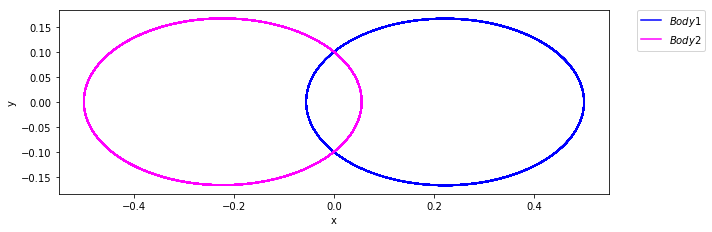

In [14]:
fig = plt.figure(figsize=(10,10), num='pendulum')
ax = fig.add_subplot(1,1,1)

ax.plot(x_pos1, y_pos1, linestyle='solid', color = 'blue',\
        label=rf'$Body 1$')

ax.plot(x_pos2, y_pos2, linestyle='solid', color = 'magenta',\
        label=rf'$Body 2$')

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

ax.set_xlabel('x')
ax.set_ylabel('y')
#ax.set_xlim(-2,2)
#ax.set_ylim(-2,2)
ax.set_aspect(1)

fig.tight_layout();

Lets check the motion using solve_ivp.

In [15]:
delta_t_ivp = 0.001
t_pts_ivp = np.arange(t_start, t_stop + delta_t_ivp, delta_t_ivp)

In [16]:
x_pos1_ivp, x1pos_dot, y_pos1_ivp, y1pos_dot,\
x_pos2_ivp, x2pos_dot, y_pos2_ivp, y2pos_dot= orbit.ODE_ivp(t_pts = t_pts_ivp,
                                                    x1_0 = x1_0, x1_0_dot = x1_dot_0,
                                                    y1_0 = y1_0, y1_0_dot = y1_dot_0,
                                                    x2_0 = x2_0, x2_0_dot = x2_dot_0,
                                                    y2_0 = y2_0, y2_0_dot = y2_dot_0)

The solver successfully reached the end of the integration interval. True


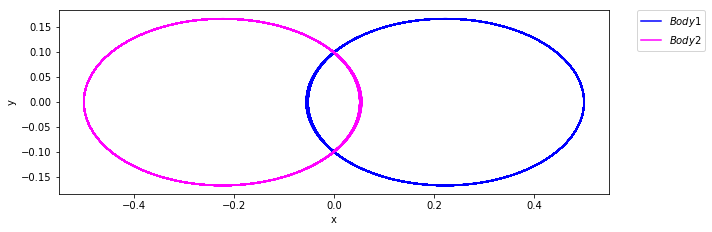

In [17]:
fig = plt.figure(figsize=(10,10), num='pendulum')
ax = fig.add_subplot(1,1,1)

ax.plot(x_pos1_ivp, y_pos1_ivp, linestyle='solid', color = 'blue',\
        label=rf'$Body 1$')

ax.plot(x_pos2_ivp, y_pos2_ivp, linestyle='solid', color = 'magenta',\
        label=rf'$Body 2$')

#ax.legend('lower_left')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_aspect(1)

fig.tight_layout();

The motion for the two body system is seen using the same initial condition as the leapfrog method in general shape. Now move to rest frame of the first mass. To get to the rest frame, set one mass as zero then the cartesian position of the second mass is given by:<br/>
$ 
X = (x_2 - x_1)
\\
Y = (y_2 - y_1)
$<br/>
where body 1 has the heavier mass.

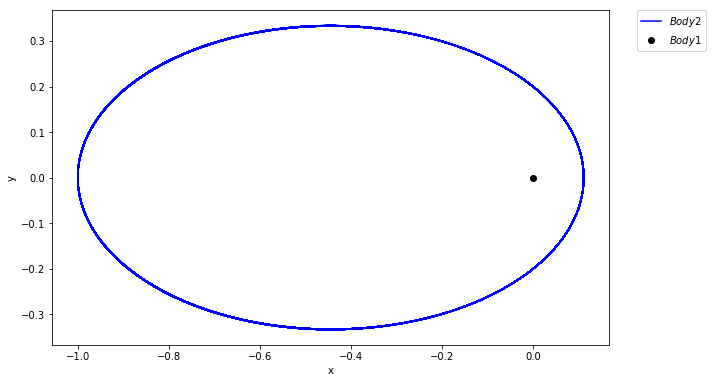

In [18]:
X = (x_pos2 - x_pos1)
Y = (y_pos2 - y_pos1)


fig = plt.figure(figsize=(10,10), num='pendulum')
ax = fig.add_subplot(1,1,1)

ax.plot(X, Y, linestyle='solid', color = 'blue',\
        label=rf'$Body 2$')

ax.plot(0., 0.,'o', color = 'black',\
        label=rf'$Body 1$')

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

ax.set_xlabel('x')
ax.set_ylabel('y')
#ax.set_xlim(-20,20)
#ax.set_ylim(-20,20)
ax.set_aspect(1)

fig.tight_layout();

The motion of the leapfrog can now be animated.

In [19]:
%%capture
        
fig_anim = plt.figure(figsize=(10,5), num = 'anim')

#information for theta vs time animation
ax_anim = fig_anim.add_subplot(1,1,1)

# lines of body path versus time plot
line_anim_angle, = ax_anim.plot(x_pos1, y_pos1, linestyle = 'dotted',
                                color = 'blue', lw=2)
line_anim_angle2, = ax_anim.plot(x_pos2, y_pos2, linestyle = 'dotted',
                                color = 'red', lw=2)

# points that trace angle versus time plot
pt_anim, = ax_anim.plot(x_pos1[0], y_pos1[0], 'o',
                              markersize=8, color='blue')
pt_anim2, = ax_anim.plot(x_pos2[0], y_pos2[0], 'o',
                               markersize=8, color='red')
        
#information for animation
ax_anim.set_aspect(1)
ax_anim.axis('off')

fig_anim.tight_layout()
        

In [20]:
def animate(i):
    """
    This is the function called by FuncAnimation to create each frame,
    numbered by i.  So each i corresponds to a point in the t_pts
    array, with index i.
    """
    i_skip = 100 * i
    
    #info for first body
    pt1_x = x_pos1[i_skip]
    pt1_y = y_pos1[i_skip]
    
    #info for second body
    pt2_x = x_pos2[i_skip]
    pt2_y = y_pos2[i_skip]
    
    #updates the position of each body
    pt_anim.set_data(pt1_x, pt1_y)
    pt_anim2.set_data(pt2_x, pt2_y)
        
    return(pt_anim, pt_anim2)

In [21]:
frame_interval = 60.  # time between frames
frame_number = int(len(t_pts)/100) # number of frames to include (index of t_pts)
anim = animation.FuncAnimation(fig_anim, 
                               animate, 
                               init_func=None,
                               frames=frame_number, 
                               interval=frame_interval, 
                               blit=True,
                               repeat=False)

In [22]:
plt.rcParams['animation.embed_limit'] = 90. 
HTML(anim.to_jshtml())

KeyboardInterrupt: 

# The Very Heavy Mass

Lets repeat for if one mass is extremely heavy compared to the other.

First create new instance of the two_body subclass.

In [60]:
# Use dynamic symbols first
q = [xt_1, yt_1, xt_2, yt_2]
q_dot = [xt_1_dot, yt_1_dot, xt_2_dot, yt_2_dot]

# These will be substituted in after solving lagranges equations.
p = [x_1, y_1, x_2, y_2]
p_dot = [x_1_dot, y_1_dot, x_2_dot, y_2_dot]
p_ddot = [x_1_ddot,  y_1_ddot, x_2_ddot, y_2_ddot]

#constants
m_sun = 333000. 
m_earth = 1. 
G_solar = 295 

heavy_mass = two_body(q = q, q_dot = q_dot,
                 p = p, p_dot = p_dot, p_ddot = p_ddot,
                 G = G_solar, m_1 = m_earth, m_2 = m_sun)

heavy_mass.Lagrangian(U = U, T = T)
heavy_mass.Lagrange()
heavy_mass.conversion()

t_start_solar = 0.
t_stop_solar = 1000.
delta_t = 0.01

t_pts_solar = arange(t_start_solar, t_stop_solar + delta_t, delta_t)

We'll use Leapfrog for time invariance. Since the system being solved is the earth-sun system, we'll use velocities and positions in the astronomical system of units. The starting point will be the perihelion of earths motion around the sun.

In [ ]:
# eccentricity of Earths orbit
e_solar = 1-0.017

### The initial conditions ###
# Earth
x1_0_solar = 9.83
y1_0_solar = 0.
x1_dot_0_solar = 0.
y1_dot_0_solar = np.sqrt(G * m_sun**2 / ((m_earth + m_sun) * x1_0) * (1 - e_solar))

# Sun
x2_0_solar = -(m_earth/m_sun) * x1_0_solar
x2_dot_0_solar = -(m_earth/m_sun) * x1_dot_0_solar
y2_0_solar = -(m_earth/m_sun) * y1_0_solar
y2_dot_0_solar = -(m_earth/m_sun) * y1_dot_0_solar

With the input initial conditions completed, the system can now be solved numerically for the cartesian coordinates of both systems.

In [ ]:
x_solar1, x_dot_so1, y_solar1, y_dot_so1, x_solar2, x_dot_so2, y_solar2, y_dot_so2\
= heavy_mass.ODE_ivp(t_pts = t_pts_solar,
                                x1_0 = x1_0_solar, x1_0_dot = x1_dot_0_solar,
                                y1_0 = y1_0_solar, y1_0_dot = y1_dot_0_solar,
                                x2_0 = x2_0_solar, x2_0_dot = x2_dot_0_solar,
                                y2_0 = y2_0_solar, y2_0_dot = y2_dot_0_solar)

Since everything ran obviously ran correctly, the motion of the earth-system should be plottable. The 

In [ ]:
fig = plt.figure(figsize=(10,10), num='pendulum')
ax = fig.add_subplot(1,1,1)

ax.plot(x_solar1, y_solar1, linestyle='solid', color = 'blue',\
        label=rf'$Earth$')

ax.plot(x_solar2, y_solar2, linestyle='solid', color = 'orange',\
        label=rf'$Sun$')

#ax.legend('lower_left')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_aspect(1)

fig.tight_layout();

To get to the Sun's rest frame, set Sun position as the zero point such that the cartesian position of the Earth in the rest frame of the sun is given by:<br/>
$ 
X = (x_{earth} - x_{Sun})
\\
Y = (y_{earth} - y_{Sun})
$<br/>

In [ ]:
X = (x_solar2 - x_solar1)
Y = (y_solar2 - y_solar1)


fig = plt.figure(figsize=(5,5), num='pendulum')
ax = fig.add_subplot(1,1,1)

ax.plot(X, Y, linestyle='solid', color = 'blue',\
        label=rf'$Earth$')

ax.plot(0., 0.,'o', color = 'orange',\
        label=rf'$Sun$')

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

ax.set_xlabel('x')
ax.set_ylabel('y')
#ax.set_xlim(-20,20)
#ax.set_ylim(-20,20)
ax.set_aspect(1)

fig.tight_layout();